<a href="https://colab.research.google.com/github/thabied/Fraud-Detection/blob/master/Xente_Fraud_Detection_Zindi_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [0]:
train = pd.read_csv('/content/drive/My Drive/Hackathon/training.csv')
test = pd.read_csv('/content/drive/My Drive/Hackathon/testing.csv')
sample = pd.read_csv('/content/drive/My Drive/Hackathon/sample_submission.csv')
explanations = pd.read_csv('/content/drive/My Drive/Hackathon/Xente_Variable_Definitions.csv')

# EDA

In [0]:
explanations

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [0]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [0]:
train.shape

(95662, 16)

In [0]:
test.shape

(45019, 15)

In [0]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB


In [0]:
train[train['FraudResult'] == 1].head(10)

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
131,TransactionId_60873,BatchId_93685,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-15T08:04:51Z,0,1
146,TransactionId_28016,BatchId_125553,AccountId_2366,SubscriptionId_4834,CustomerId_7414,UGX,256,ProviderId_5,ProductId_9,financial_services,ChannelId_1,725000.0,725000,2018-11-15T08:20:09Z,2,1
155,TransactionId_1149,BatchId_10381,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-15T08:31:57Z,0,1
2376,TransactionId_136904,BatchId_52644,AccountId_3692,SubscriptionId_3451,CustomerId_4134,UGX,256,ProviderId_1,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-17T09:15:23Z,0,1
2452,TransactionId_88818,BatchId_54481,AccountId_3832,SubscriptionId_4161,CustomerId_4275,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,700000.0,700000,2018-11-17T11:49:46Z,0,1
3778,TransactionId_65985,BatchId_34263,AccountId_2366,SubscriptionId_4834,CustomerId_7414,UGX,256,ProviderId_5,ProductId_9,financial_services,ChannelId_1,905000.0,905000,2018-11-19T12:10:31Z,2,1
4500,TransactionId_4222,BatchId_127498,AccountId_1959,SubscriptionId_1476,CustomerId_2353,UGX,256,ProviderId_3,ProductId_15,financial_services,ChannelId_3,800000.0,800000,2018-11-20T12:00:29Z,0,1
4508,TransactionId_2550,BatchId_79762,AccountId_4003,SubscriptionId_3002,CustomerId_4453,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,770000.0,770000,2018-11-20T12:27:15Z,0,1
4755,TransactionId_49480,BatchId_77828,AccountId_3943,SubscriptionId_1417,CustomerId_4391,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,500000.0,500000,2018-11-20T22:11:53Z,0,1
4911,TransactionId_66468,BatchId_89498,AccountId_4590,SubscriptionId_666,CustomerId_5054,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,500000.0,500000,2018-11-21T08:26:49Z,4,1


In [0]:
train.isnull().values.any()

False

In [0]:
train['FraudResult'].mean()

0.00201752001839811

In [0]:
sample.head()

,TransactionId,FraudResult
0,TransactionId_50600,NaN
1,TransactionId_95109,NaN
2,TransactionId_47357,NaN
3,TransactionId_28185,NaN
4,TransactionId_22140,NaN


# Feature Engineering

In [0]:
y = train[['FraudResult']]
train = train.drop(['FraudResult','BatchId','SubscriptionId','CustomerId','CountryCode','ProductId','TransactionStartTime'], axis=1)
test = test.drop(['BatchId','SubscriptionId','CustomerId','CountryCode','ProductId','TransactionStartTime'], axis=1)

data = train.append(test, sort=False)
data = data.set_index('TransactionId')

data['PricingStrategy'] = data['PricingStrategy'].astype('object')

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

data[['AccountId','CurrencyCode','ProviderId','ProductCategory','ChannelId','PricingStrategy']] = data[['AccountId','CurrencyCode','ProviderId','ProductCategory','ChannelId','PricingStrategy']].apply(encoder.fit_transform)

X = data.iloc[0:95662, :]
test = data.iloc[95662:, :]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
s_X, s_y = smote.fit_sample(X_train, y_train)
sX_df = pd.DataFrame(s_X, columns=X_train.columns)
sy_df = pd.DataFrame(s_y, columns=y_train.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
sX_df.head()

,AccountId,CurrencyCode,ProviderId,ProductCategory,ChannelId,Amount,Value,PricingStrategy
0,1.0,0.0,3.0,0.0,4.0,-1000.0,1000.0,3.0
1,4654.0,0.0,5.0,2.0,2.0,2110.0,2110.0,2.0
2,3096.0,0.0,4.0,0.0,2.0,1100.0,1100.0,3.0
3,3760.0,0.0,5.0,0.0,2.0,1000.0,1000.0,2.0
4,4269.0,0.0,3.0,2.0,1.0,-75.0,75.0,2.0


In [0]:
sy_df.mean()

FraudResult    0.5
dtype: float64

# Model Performance and Evaluation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


In [0]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [0]:
X_test = scaler.transform(X_test)

# Logistic Regression

In [0]:
lr = LogisticRegression(random_state=42)

In [0]:
lr_model = lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
lr_smote = lr.fit(sX_df, sy_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
y_pred = lr_model.predict(X_test)

In [0]:
f1_score(y_test, y_pred)

0.4545454545454545

In [0]:
def tune_model(X_train, y_train): 
    
    C_list = [0.001,0.01,0.1, 1,2,5,10]
    
    log = LogisticRegression()
    parameters = {'C':(C_list)}
    
    clf = GridSearchCV(log, parameters)
    best = clf.fit(X_train,y_train)
    return best.best_params_

tune_model(X_train, y_train)

In [0]:
logistic = LogisticRegression(C=0.001, class_weight='balanced',solver='liblinear', penalty='l1')

In [0]:
lr_model = lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
y_pred = lr_model.predict(X_test)

In [0]:
accuracy_score(y_test, y_pred)

0.8427947598253275

# Random Forest

In [0]:
rf = RandomForestClassifier(random_state=42)

In [0]:
rf_model = rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
rf_smote = rf.fit(sX_df, sy_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
y_pred = rf_model.predict(X_test)

In [0]:
f1_score(y_test, y_pred)

0.9069767441860465

In [0]:
f1_score(y_test, y_pred)

0.8799999999999999

In [0]:
# create the grid
n_estimators = [1000, 1500]
max_depth = [None, 10]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [0]:
# create the default model
rf = RandomForestClassifier(random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [0]:
grid_result.best_params_

{'max_depth': None, 'n_estimators': 1000}

In [0]:
# create the grid
leaf_samples = [1,5]
param_grid = dict(min_samples_leaf=leaf_samples)

# create the model with new max_depth and n_estimators
rf = grid_result.best_estimator_

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.1s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [0]:
grid_result.best_params_

{'min_samples_leaf': 1}

In [0]:
# create the grid
max_features = [None, 5]
bootstrap = [True, False]
param_grid = dict(max_features=max_features, bootstrap=bootstrap)

In [0]:
# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [0]:
grid_result.best_params_

{'bootstrap': True, 'max_features': 5}

In [0]:
rf = RandomForestClassifier(max_depth = None,
                            n_estimators = 1000,
                            min_samples_leaf = 1,
                            bootstrap = True,
                            max_features = 5,
                            random_state = 42
                            )

In [0]:
rf_model = rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
rf_smote = rf.fit(sX_df, sy_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
y_pred = rf_model.predict(X_test)

In [0]:
y_pred = rf_smote.predict(X_test)

In [0]:
f1_score(y_test, y_pred)

0.8799999999999999

In [0]:
f1_score(y_test, y_pred)

0.8627450980392156

# GB Classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
gb = GradientBoostingClassifier()
gb_smote = gb.fit(sX_df, sy_df)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
import xgboost as xgb

In [0]:
XgbClassifier = xgb.XGBClassifier()

In [0]:
xgb_smote = XgbClassifier.fit(sX_df, sy_df)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Neural Network

In [0]:
def create_model(lyrs=[4], act='linear', opt='SGD', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_random_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [0]:
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_acc'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 94.39%


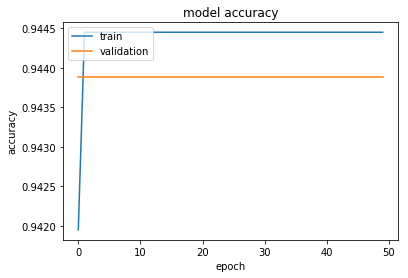

In [0]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [25, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=2,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] batch_size=16, epochs=25 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.820569 using {'batch_size': 32, 'epochs': 50}
0.816193 (0.016540) with: {'batch_size': 16, 'epochs': 25}
0.816193 (0.002694) with: {'batch_size': 16, 'epochs': 50}
0.773523 (0.037834) with: {'batch_size': 32, 'epochs': 25}
0.820569 (0.010040) with: {'batch_size': 32, 'epochs': 50}
0.781182 (0.019967) with: {'batch_size': 64, 'epochs': 25}
0.788840 (0.013195) with: {'batch_size': 64, 'epochs': 50}


In [0]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   4.5s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] .......................................... opt=SGD, total=   4.6s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   4.6s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.0s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.3s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   5.1s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   5.0s
[CV] opt=Adagrad .....................................................
[CV] ...................................... opt=Adagrad, total=   5.1s
[CV] opt=Adagrad .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.844639 using {'opt': 'SGD'}
0.844639 (0.023041) with: {'opt': 'SGD'}
0.826039 (0.019036) with: {'opt': 'RMSprop'}
0.828228 (0.025179) with: {'opt': 'Adagrad'}
0.822757 (0.023496) with: {'opt': 'Adadelta'}
0.833698 (0.024584) with: {'opt': 'Adam'}
0.814004 (0.019685) with: {'opt': 'Nadam'}


In [0]:
seed(42)
set_random_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[4],[6],[8],[10], [8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] lyrs=[4] ........................................................
[CV] ......................................... lyrs=[4], total=  13.0s
[CV] lyrs=[4] ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


[CV] ......................................... lyrs=[4], total=  13.2s
[CV] lyrs=[4] ........................................................
[CV] ......................................... lyrs=[4], total=  13.3s
[CV] lyrs=[6] ........................................................
[CV] ......................................... lyrs=[6], total=  13.3s
[CV] lyrs=[6] ........................................................
[CV] ......................................... lyrs=[6], total=  13.4s
[CV] lyrs=[6] ........................................................
[CV] ......................................... lyrs=[6], total=  13.2s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=  13.4s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=  13.4s
[CV] lyrs=[8] ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.4min finished


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.818381 using {'lyrs': [4]}
0.818381 (0.013055) with: {'lyrs': [4]}
0.815098 (0.010961) with: {'lyrs': [6]}
0.817287 (0.006334) with: {'lyrs': [8]}
0.815098 (0.010570) with: {'lyrs': [10]}
0.808534 (0.007911) with: {'lyrs': [8, 4]}


In [0]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dr=0.0 ..........................................................
[CV] ........................................... dr=0.0, total=   8.7s
[CV] dr=0.0 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ........................................... dr=0.0, total=   8.4s
[CV] dr=0.0 ..........................................................


W0701 11:18:06.982786 139815125723008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[CV] ........................................... dr=0.0, total=   8.5s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   8.8s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   8.9s
[CV] dr=0.01 .........................................................
[CV] .......................................... dr=0.01, total=   9.4s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   9.3s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   9.2s
[CV] dr=0.05 .........................................................
[CV] .......................................... dr=0.05, total=   9.4s
[CV] dr=0.1 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.8min finished


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.833698 using {'dr': 0.0}
0.833698 (0.024584) with: {'dr': 0.0}
0.816193 (0.023506) with: {'dr': 0.01}
0.820569 (0.033027) with: {'dr': 0.05}
0.811816 (0.023091) with: {'dr': 0.1}
0.810722 (0.022611) with: {'dr': 0.2}
0.827133 (0.029864) with: {'dr': 0.5}


In [0]:
# create final model
model = create_model(lyrs=[4], dr=0.0)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 296       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# train model on full train set, with 80/20 CV split
training = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2, verbose=0)

# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

914/914 [==============================] - 0s 39us/step

acc: 83.15%


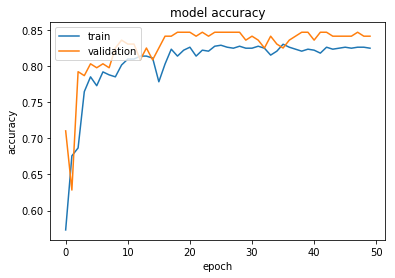

In [0]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred = pd.DataFrame(y_pred, columns=['floats'])

In [0]:
y_pred['int'] = [1 if x>0.8 else 0 for x in y_pred['floats']]
#y['Mind'] = [1 if 'E' in x else 0 for x in new_train['type']]

In [0]:
y_pred.head()

,floats,int
0,0.254969,0
1,0.226333,0
2,0.163371,0
3,0.218267,0
4,0.224826,0


In [0]:
accuracy_score(y_test, y_pred['int'])

0.8296943231441049

# Predict on Test Set

In [0]:
answer = lr_smote.predict(test)

In [0]:
answer = rf_smote.predict(test)

In [0]:
answer = gb_smote.predict(test)

In [0]:
answer = xgb_smote.predict(test)

In [0]:
answer = model.predict(test)

In [0]:
answer = answer.reshape(-1,1)
answer = pd.DataFrame(answer, columns=['FraudResult'])
answer.index = test.index

In [0]:
#answer['FraudResult'] = answer['FraudResult'].astype(int)

In [0]:
answer.head()

,FraudResult
TransactionId,
TransactionId_50600,0
TransactionId_95109,0
TransactionId_47357,0
TransactionId_28185,0
TransactionId_22140,0


In [0]:
from google.colab import files
answer.to_csv('sub10.csv')
files.download('sub10.csv')